In [7]:
%matplotlib inline

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.special import comb

In [9]:
# Global variables

# Queue size
MAX_QUEUE_SIZE = 20

# Arrival average of customers per unit time (Poisson process)
ARRIVAL_SIMPLE = 12
ARRIVAL_COMPLEX = 5

# Service rate of agents for each query types (Exponential distribution)
## Agent 1
SERVICE_SIMPLE_1 = 12
SERVICE_COMPLEX_1 = 3
## Agent 2
SERVICE_SIMPLE_2 = 6
SERVICE_COMPLEX_2 = 5

# Discount factor for future rewards
DISCOUNT = 0.95

# Penalty for dropping calls (when queue is full)
DROP_PENALTY = 100.0

# State space: (queue 1 size, queue 2 size, call type)
STATE_SPACE = (MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2)

# Call type: 0 = simple, 1 = complex
CALL_TYPE = [0, 1]

# Actions: 1 = route to queue 1, 2 = route to queue 2
ACTIONS = [0, 1]

In [10]:
def calculate_transition_probabilities(q1, q2, action):
    """
    Calculate transition probabilities based on event rates
    """
    
    # Initialise rates based on queue conditions
    rate_simple_dep_1 = SERVICE_SIMPLE_1 if q1 > 0 else 0
    rate_complex_dep_1 = SERVICE_COMPLEX_1 if q1 > 0 else 0
    rate_simple_dep_2 = SERVICE_SIMPLE_2 if q2 > 0 else 0
    rate_complex_dep_2 = SERVICE_COMPLEX_2 if q2 > 0 else 0
    
    # Check if arrivals are possible (queues not full)
    queue1_full = q1 == MAX_QUEUE_SIZE
    queue2_full = q2 == MAX_QUEUE_SIZE
    drop_if_action0 = queue1_full and action == 0
    drop_if_action1 = queue2_full and action == 1
    
    queues_full = (queue1_full and queue2_full) or drop_if_action0 or drop_if_action1
    
    # Track drops
    will_drop_simple = queues_full
    will_drop_complex = queues_full
    
    # Set arrival rate to 0 if queues are full
    rate_simple_arr = ARRIVAL_SIMPLE if not will_drop_simple else 0
    rate_complex_arr = ARRIVAL_COMPLEX if not will_drop_complex else 0
    
    # Calculate rates for dropped calls
    rate_simple_drop = ARRIVAL_SIMPLE if will_drop_simple else 0
    rate_complex_drop = ARRIVAL_COMPLEX if will_drop_complex else 0
    
    # Calculate total rate after applying conditions
    total_rate = (rate_simple_dep_1 + rate_complex_dep_1 + 
                  rate_simple_dep_2 + rate_complex_dep_2 + 
                  rate_simple_arr + rate_complex_arr +
                  rate_simple_drop + rate_complex_drop)
    
    # Calculate probabilities
    return {
        'simple_dep_1': rate_simple_dep_1 / total_rate if total_rate > 0 else 0,
        'complex_dep_1': rate_complex_dep_1 / total_rate if total_rate > 0 else 0,
        'simple_dep_2': rate_simple_dep_2 / total_rate if total_rate > 0 else 0,
        'complex_dep_2': rate_complex_dep_2 / total_rate if total_rate > 0 else 0,
        'simple_arr': rate_simple_arr / total_rate if total_rate > 0 else 0,
        'complex_arr': rate_complex_arr / total_rate if total_rate > 0 else 0,
        'simple_drop': rate_simple_drop / total_rate if total_rate > 0 else 0,
        'complex_drop': rate_complex_drop / total_rate if total_rate > 0 else 0,
        'will_drop_simple': will_drop_simple,
        'will_drop_complex': will_drop_complex
    }

def expected_waiting_time(state, action):
    """
    Expected waiting times accounting for all possible queue compositions
    """
    
    q1, q2, call_type = state
    
    wait = 0.0
    
    # Probability of call being simple or complex
    p_simple = ARRIVAL_SIMPLE / (ARRIVAL_SIMPLE + ARRIVAL_COMPLEX)
    p_complex = ARRIVAL_COMPLEX / (ARRIVAL_SIMPLE + ARRIVAL_COMPLEX)
    
    if action == 0:
        # Route to queue 1
        # Account for existing queue composition
        for k in range(q1 + 1):  # k is number of simple calls
            # Binomial probability of having k simple calls in queue of size q1
            if q1 > 0:
                prob = comb(q1, k) * (p_simple**k) * (p_complex**(q1-k))
                # Expected waiting time with this composition
                wait_k = (k / SERVICE_SIMPLE_1) + ((q1-k) / SERVICE_COMPLEX_1)
                wait += prob * wait_k
            
        # Add service time for current call
        if call_type == 0:  # Simple call
            wait += 1 / SERVICE_SIMPLE_1
        else:  # Complex call
            wait += 1 / SERVICE_COMPLEX_1
    else:
        # Route to queue 2 (similar calculation)
        for k in range(q2 + 1):
            if q2 > 0:
                prob = comb(q2, k) * (p_simple**k) * (p_complex**(q2-k))
                wait_k = (k / SERVICE_SIMPLE_2) + ((q2-k) / SERVICE_COMPLEX_2)
                wait += prob * wait_k
            
        if call_type == 0:
            wait += 1 / SERVICE_SIMPLE_2
        else:
            wait += 1 / SERVICE_COMPLEX_2
            
    return wait  # We don't negate this but use argmin

def expected_future_cost(action, value, q1, q2, call_type):
    """
    Calculate expected cost for the next state based on action taken
    """
    
    # Initialise expected next state value
    expected_next_cost = 0.0
    
    # Calculate next state based on action
    next_q1 = q1
    next_q2 = q2
    
    # Check if action would result in a drop
    queue1_full = next_q1 == MAX_QUEUE_SIZE
    queue2_full = next_q2 == MAX_QUEUE_SIZE
    will_drop = (queue1_full and queue2_full) or \
            (queue1_full and action == 0) or \
            (queue2_full and action == 1)
            
    if will_drop:
        # If the call is dropped, apply drop penalty
        expected_next_cost += DROP_PENALTY
    else:
        # If not dropped, update the next state based on action
        if action == 0:
            next_q1 = min(q1 + 1, MAX_QUEUE_SIZE)
        else:
            next_q2 = min(q2 + 1, MAX_QUEUE_SIZE)
        
    # Get transition probabilities
    trans_probs = calculate_transition_probabilities(next_q1, next_q2, action)
    
    # Consider all possible next events
    # 1. Departures from queue 1 (if queue not empty)
    if next_q1 > 0:
        next_state_val = value[next_q1-1, next_q2, call_type]
        expected_next_cost += trans_probs['simple_dep_1'] * next_state_val
        expected_next_cost += trans_probs['complex_dep_1'] * next_state_val
    
    # 3. Departures from queue 2 (if queue not empty)
    if next_q2 > 0:
        next_state_val = value[next_q1, next_q2-1, call_type]
        expected_next_cost += trans_probs['simple_dep_2'] * next_state_val
        expected_next_cost += trans_probs['complex_dep_2'] * next_state_val
        
    # 4. Add penalties for future drops based on transition probabilities
    future_drop_cost = 0.0
    if trans_probs['will_drop_simple']:
        future_drop_cost += DROP_PENALTY * trans_probs['simple_drop']
    if trans_probs['will_drop_complex']:
        future_drop_cost += DROP_PENALTY * trans_probs['complex_drop']
        
    expected_next_cost += future_drop_cost
    
    # 5. Simple arrival
    next_state_val = value[min(next_q1, MAX_QUEUE_SIZE), min(next_q2, MAX_QUEUE_SIZE), 0]
    expected_next_cost += trans_probs['simple_arr'] * next_state_val
    
    # 6. Complex arrival
    next_state_val = value[min(next_q1, MAX_QUEUE_SIZE), min(next_q2, MAX_QUEUE_SIZE), 1]
    expected_next_cost += trans_probs['complex_arr'] * next_state_val
    
    return expected_next_cost
    

In [11]:
def policy_evaluation(policy_simple, policy_complex, value, threshold=1e-4):
    """
    Evaluate the policy by calculating state values
    """
    
    while True:
        delta = 0
        
        old_value = value.copy()
        
        # For each state
        for q1 in range(MAX_QUEUE_SIZE + 1):
            for q2 in range(MAX_QUEUE_SIZE + 1):
                for call_type in CALL_TYPE:
                    
                    # Get action from policy
                    if call_type == 0:
                        action = policy_simple[q1, q2]
                    else:
                        action = policy_complex[q1, q2]
                        
                    if (action == 0 and q1 == MAX_QUEUE_SIZE) or (action == 1 and q2 == MAX_QUEUE_SIZE):
                        continue
                        
                    waiting_cost = expected_waiting_time((q1, q2, call_type), action)
                    
                    # Calculate expected next state value
                    expected_next_cost = expected_future_cost(action, old_value, q1, q2, call_type)
                        
                    # Update value function
                    value[q1, q2, call_type] = waiting_cost + DISCOUNT * expected_next_cost
                    
        # Track the maximum change in value
        delta = np.max(np.abs(old_value - value))
        
        print(f"Delta: {delta}")
        
        # Check for convergence
        if delta < threshold:
            break
    
    return value
                    
                    
def policy_improvement(value):
    """
    Improve policy based on current value function
    """
    
    policy_simple = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
    policy_complex = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
    
    # For each state
    for q1 in range(MAX_QUEUE_SIZE + 1):
        for q2 in range(MAX_QUEUE_SIZE + 1):
            # For simple calls
            action_values = []
            for action in ACTIONS:
                
                # Calculate expected waiting times
                waiting_cost = expected_waiting_time((q1, q2, 0), action)
                
                # Calculate next state based on action
                expected_next_cost = expected_future_cost(action, value, q1, q2, 0)
                
                action_values.append(waiting_cost + DISCOUNT * expected_next_cost)
            
            # Choose the action with the minimum expected waiting time
            if len(action_values) > 0:
                policy_simple[q1, q2] = ACTIONS[np.argmin(action_values)]
            else:
                # Default action if all actions are invalid
                policy_simple[q1, q2] = 0
                
            # For complex calls
            action_values = []
            for action in ACTIONS:
                
                # Calculate expected waiting times
                waiting_cost = expected_waiting_time((q1, q2, 1), action)
                
                # Calculate next state based on action
                expected_next_cost = expected_future_cost(action, value, q1, q2, 1)
                
                action_values.append(waiting_cost + DISCOUNT * expected_next_cost)
            
            # Choose the action with the minimum expected waiting time
            if len(action_values) > 0:
                policy_complex[q1, q2] = ACTIONS[np.argmin(action_values)]
            else:
                # Default action if all actions are invalid
                policy_complex[q1, q2] = 1
    
    return policy_simple, policy_complex
                

Iteration 1
Delta: 61.23151260504201
Delta: 29.755439824388386
Delta: 19.205227554977117
Delta: 14.906462543468209
Delta: 11.725789811971822
Delta: 9.82935906572962
Delta: 8.151860895780882
Delta: 7.050096548605715
Delta: 6.142749392181209
Delta: 5.279043454576318
Delta: 4.740296887214072
Delta: 4.147866698345442
Delta: 3.7571661497706685
Delta: 3.3461171873136664
Delta: 3.0414213942157247
Delta: 2.773561968699802
Delta: 2.5285994266356226
Delta: 2.3166692911174884
Delta: 2.1191866453961126
Delta: 1.947036612794129
Delta: 1.805217200793681
Delta: 1.664479545167513
Delta: 1.544167480737098
Delta: 1.4264993581650565
Delta: 1.3233959036842684
Delta: 1.2344952316616045
Delta: 1.1462595252259717
Delta: 1.0700611784012324
Delta: 0.9950877587855729
Delta: 0.9279036792075495
Delta: 0.8699192409395735
Delta: 0.8120627877907793
Delta: 0.7604324667986901
Delta: 0.7109731707431308
Delta: 0.6658939831610908
Delta: 0.6256991855975222
Delta: 0.5868722429244713
Delta: 0.5506762982036477
Delta: 0.51789

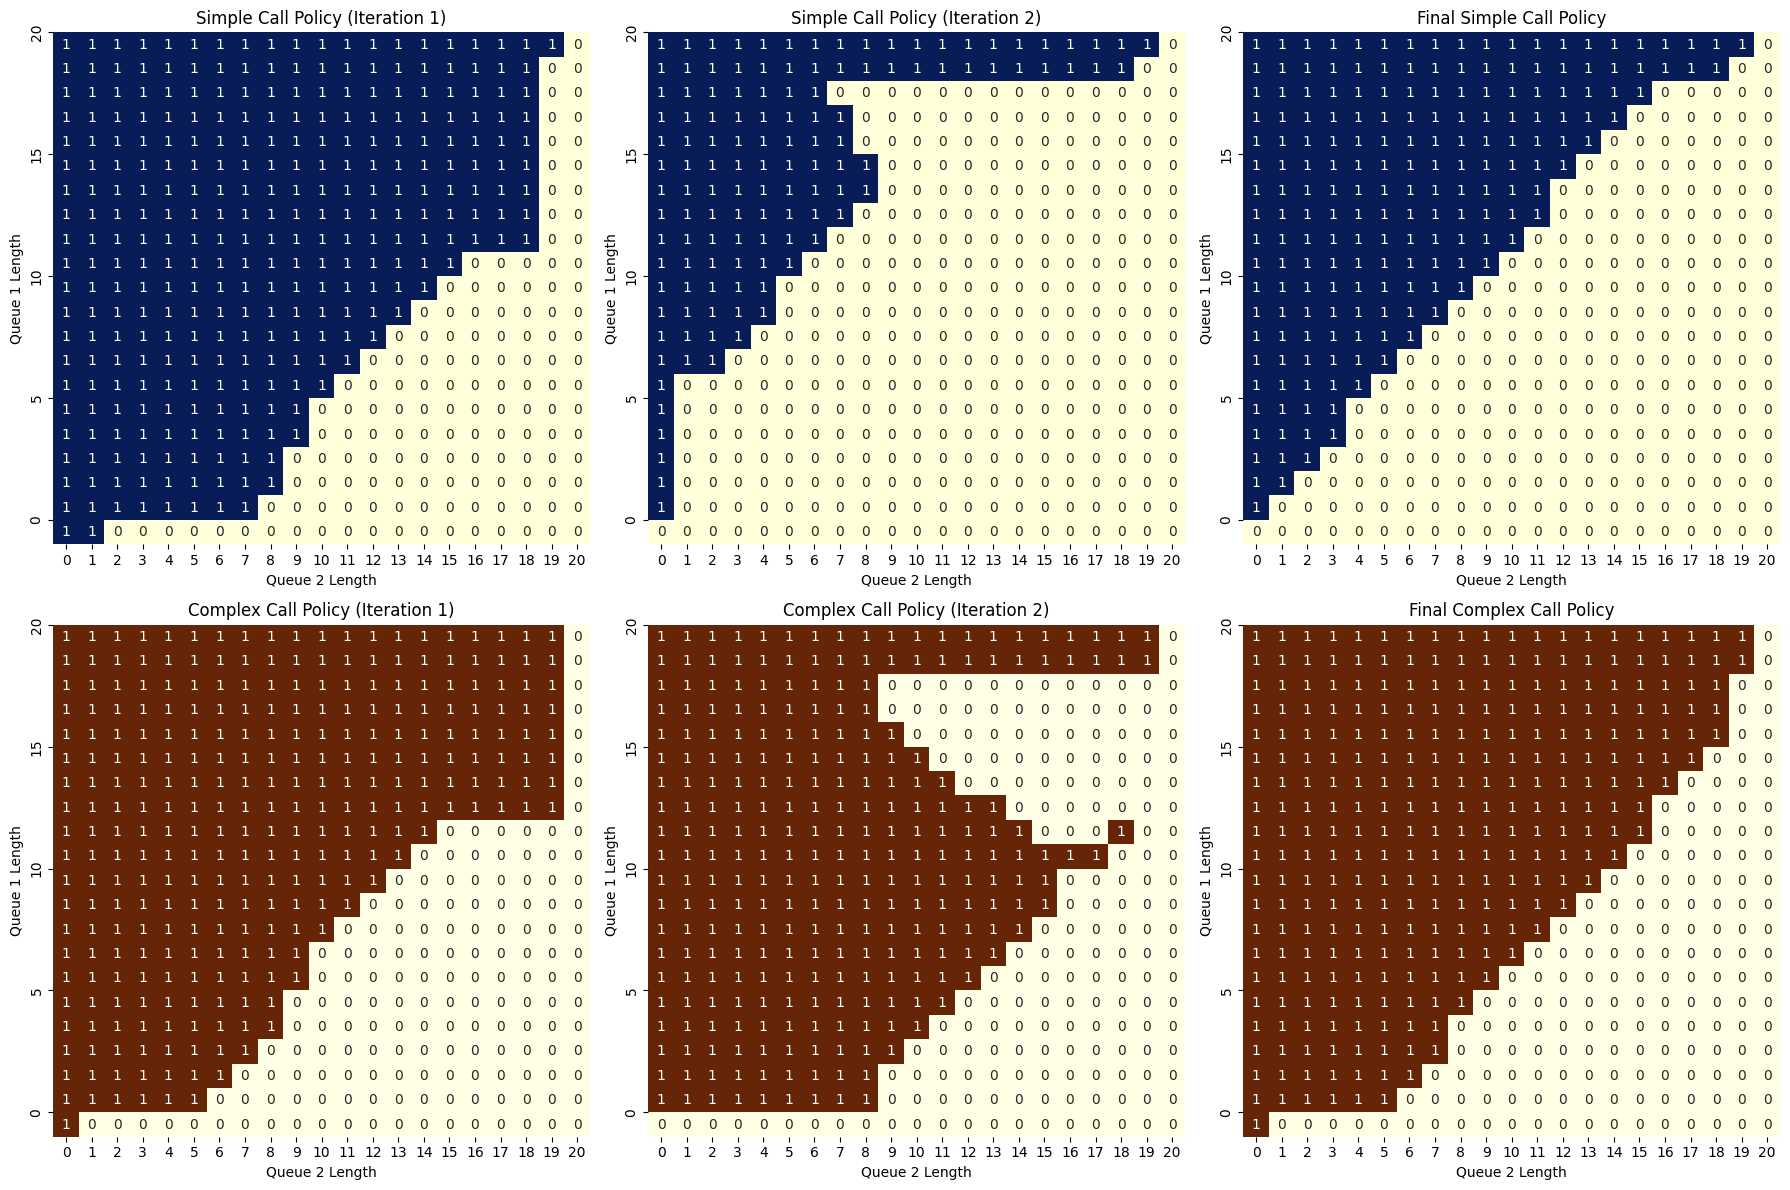

In [12]:
# Run policy iteration algorithm

# Initialise policies
policy_simple = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
policy_complex = np.ones((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)

# Initialise value function
value = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2))

# For visualisation
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
iteration = 0
max_iterations = 20

while iteration < max_iterations:
    print(f"Iteration {iteration+1}")
    
    # Policy iteration
    # Policy evaluation
    value = policy_evaluation(policy_simple, policy_complex, value)
    
    # Policy improvement
    new_policy_simple, new_policy_complex = policy_improvement(value)
    
    # Check if policies have changed
    if np.array_equal(policy_simple, new_policy_simple) and np.array_equal(policy_complex, new_policy_complex):
        print("Policies have converged")
        policy_simple, policy_complex = new_policy_simple, new_policy_complex
        break
    
    policy_simple, policy_complex = new_policy_simple, new_policy_complex
    
    # Visualise current policies
    if iteration < 2:
        # Simple call policy
        sns.heatmap(np.flipud(policy_simple), cmap="YlGnBu", ax=axes[0, iteration], annot=np.flipud(policy_simple),
                    cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
        axes[0, iteration].set_title(f'Simple Call Policy (Iteration {iteration+1})')
        axes[0, iteration].set_ylabel('Queue 1 Length')
        axes[0, iteration].set_xlabel('Queue 2 Length')
        axes[0, iteration].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
        axes[0, iteration].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))
        
        # Complex call policy
        sns.heatmap(np.flipud(policy_complex), cmap="YlOrBr", ax=axes[1, iteration], annot=np.flipud(policy_complex),
                    cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
        axes[1, iteration].set_title(f'Complex Call Policy (Iteration {iteration+1})')
        axes[1, iteration].set_ylabel('Queue 1 Length')
        axes[1, iteration].set_xlabel('Queue 2 Length')
        axes[1, iteration].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
        axes[1, iteration].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))
    
    iteration += 1
    
# Final policies visualisation
# Simple call policy
sns.heatmap(np.flipud(policy_simple), cmap="YlGnBu", ax=axes[0, 2], annot=np.flipud(policy_simple),
            cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
axes[0, 2].set_title('Final Simple Call Policy')
axes[0, 2].set_ylabel('Queue 1 Length')
axes[0, 2].set_xlabel('Queue 2 Length')
axes[0, 2].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
axes[0, 2].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))

# Complex call policy
sns.heatmap(np.flipud(policy_complex), cmap="YlOrBr", ax=axes[1, 2], annot=np.flipud(policy_complex),
            cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
axes[1, 2].set_title('Final Complex Call Policy')
axes[1, 2].set_ylabel('Queue 1 Length')
axes[1, 2].set_xlabel('Queue 2 Length')
axes[1, 2].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
axes[1, 2].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))

plt.tight_layout()
plt.show()

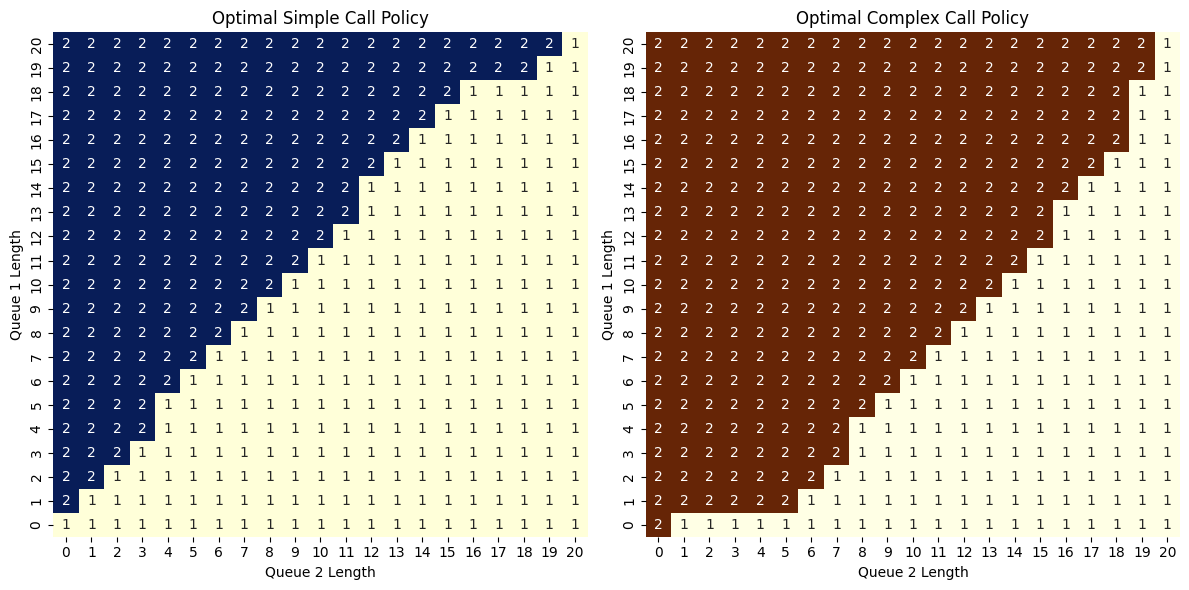

In [24]:
# Visualise only final policies

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Simple call policy
sns.heatmap(np.flipud(policy_simple), cmap="YlGnBu", ax=ax[0], 
            annot=np.flipud(policy_simple + 1), fmt='d', cbar=False)
ax[0].set_title('Optimal Simple Call Policy')
ax[0].set_ylabel('Queue 1 Length')
ax[0].set_xlabel('Queue 2 Length')
ax[0].set_yticks(list(reversed(np.arange(0.5, MAX_QUEUE_SIZE + 1, 1))))
ax[0].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 1))
# Complex call policy
sns.heatmap(np.flipud(policy_complex), cmap="YlOrBr", ax=ax[1], 
            annot=np.flipud(policy_complex + 1), fmt='d', cbar=False)
ax[1].set_title('Optimal Complex Call Policy')
ax[1].set_ylabel('Queue 1 Length')
ax[1].set_xlabel('Queue 2 Length')
ax[1].set_yticks(list(reversed(np.arange(0.5, MAX_QUEUE_SIZE + 1, 1))))
ax[1].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 1))
plt.tight_layout()
plt.show()

In [26]:
# Alternate policies
alt_simple_policy = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
for i in range(MAX_QUEUE_SIZE + 1):
    for j in range(MAX_QUEUE_SIZE + 1):
        if i < j:
            alt_simple_policy[i, j] = 0  # Route to queue 1
        elif i > j:
            alt_simple_policy[i, j] = 1  # Route to queue 2
            
alt_complex_policy = np.ones((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
for i in range(MAX_QUEUE_SIZE + 1):
    for j in range(MAX_QUEUE_SIZE + 1):
        if i < j:
            alt_complex_policy[i, j] = 0  # Route to queue 1
        elif i > j:
            alt_complex_policy[i, j] = 1  # Route to queue 2

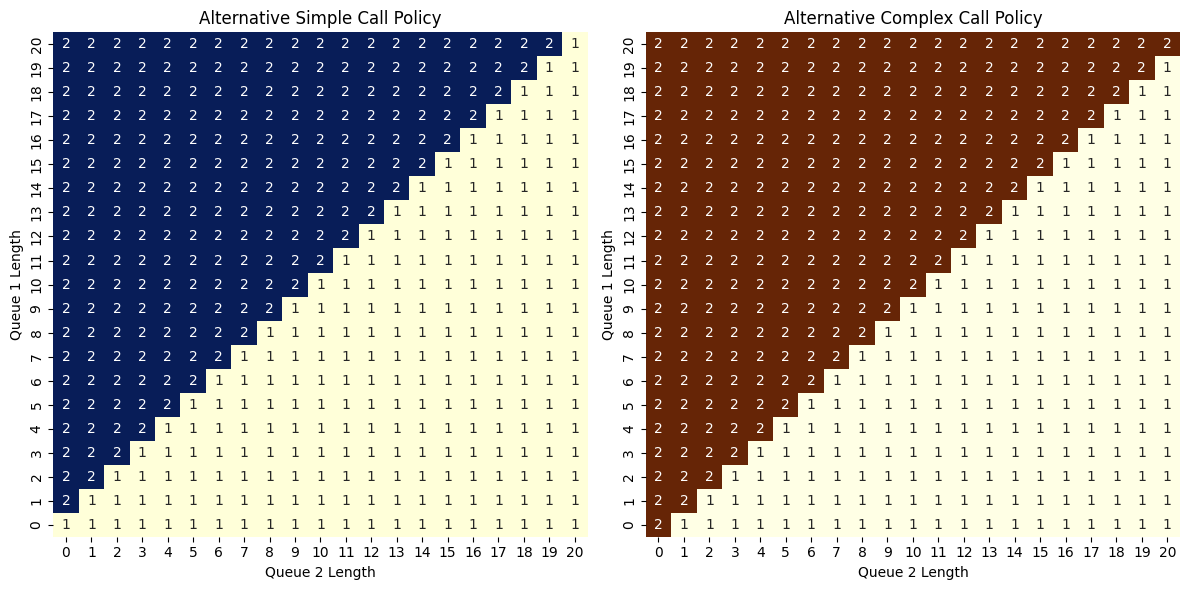

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Simple call policy
sns.heatmap(np.flipud(alt_simple_policy), cmap="YlGnBu", ax=ax[0], 
            annot=np.flipud(alt_simple_policy + 1), fmt='d', cbar=False)
ax[0].set_title('Alternative Simple Call Policy')
ax[0].set_ylabel('Queue 1 Length')
ax[0].set_xlabel('Queue 2 Length')
ax[0].set_yticks(list(reversed(np.arange(0.5, MAX_QUEUE_SIZE + 1, 1))))
ax[0].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 1))
# Complex call policy
sns.heatmap(np.flipud(alt_complex_policy), cmap="YlOrBr", ax=ax[1], 
            annot=np.flipud(alt_complex_policy + 1), fmt='d', cbar=False)
ax[1].set_title('Alternative Complex Call Policy')
ax[1].set_ylabel('Queue 1 Length')
ax[1].set_xlabel('Queue 2 Length')
ax[1].set_yticks(list(reversed(np.arange(0.5, MAX_QUEUE_SIZE + 1, 1))))
ax[1].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 1))
plt.tight_layout()
plt.show()

In [19]:
# Save the policies to pickles

with open('policy_simple_withdrop.pkl', 'wb') as f:
    pickle.dump(policy_simple, f)
    
with open('policy_complex_withdrop.pkl', 'wb') as f:
    pickle.dump(policy_complex, f)

### What to implement next:

* Save policies into pickles ✅
* Simulation using the optimal policies ✅
* Comparison between optimal policies with another policies ✅
* Introduce drop penalties ✅
* (?) Update proportion based on simulation ❌ (canceled because we no longer use proportions, used combinations and probabilities instead)